# Increasing mitochondrial mutational load with age

We use single-cell RNA-sequencing data from Enge et al. to demonstrate that the mitochondrial load is increasing with age.


In [5]:
# load libraries for analysis and plotting

import numpy as np
import pandas as pd
import scanpy as sc
import os
import argparse
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# set seaborn plotting options (not mandatory)
sns.set_context("paper")
sns.set_style("white")
sns.set(font_scale=1.2) 
sns.set_style("white")

First, we load the data.

In [11]:
# Load the dataframe with mutation information
varianceData = pkl.load( open( "./../../data/precomputedData/Enge/engeVariantsSTAR200.pkl", "rb" ) )
# expression matrix
adata = sc.read_h5ad("./../../data/precomputedData/Enge/engeFilteredExpression200.h5ad")
# metadata
metadata = pkl.load( open( "./../../data/precomputedData/Enge/enge_metadata.pkl", "rb" ) )

In [13]:
# add age and cell type as annotations to the expression matrix 
# get all ages from the variance data
age = [ metadata[metadata['SRR_id'] == item]['donor_age'].iloc[0] if (item in metadata['SRR_id'].values) else 0 for item in adata.obs_names]
# add it to the expression matrix
adata.obs['donor_age'] = age
# cellType = [ metadata[metadata['SRR_id'] == item]['inferred_cell_type'].iloc[0] if (item in metadata['SRR_id'].values) else 0 for item in adata.obs_names]
# adata.obs['cell_type'] = cellType

These are functions that take the gene expression matrix and the dataframe with the mutation information to compute the mitochondrial load and identify differentially expressed genes.

In [14]:
# define a function that computes mitochondrial load and adds it to the data frame
def computeMitochondrialLoad(expressionMatrix,varianceDataFrame,
                             threshold = 0.05, #threshold: heteroplasmy threshold (only mutations above this threshold are considered)
                             mutantType = 'all', # which type of mutations should be considered, list of strings, e.g., ['Common mutation','Developmental']
                             removeSynonymous = 0, # whether to remove synonymous mutations from the mutations
                             pathologyType = 'all', # which type of pathology we look at
                             subsetCells = 'all', # whether to keep only certain type of cells
                             rescaling= False, # rescaling by considering the number of bases passed (not recommended)
                             muName = 'MU' # name given to the mitochondrial load in the expression matrix Anndata object
                            ): 
    
    # Apply heteroplasmy threshold 
    varianceDataFrame = varianceDataFrame[threshold<varianceDataFrame['HF']]
    
    # Keep only certain type of mutations
    if (mutantType == 'all'):
        pass
    else:
        # keep only variance which is in this list
         varianceDataFrame = varianceDataFrame[varianceDataFrame['mutant_type'].isin(mutantType)]
    
    # Keep only synonomous or non-synonomous mutation
    if removeSynonymous == True:
        varianceDataFrame= varianceDataFrame[~(varianceDataFrame['MutPred_Prediction'] == 'Synonymous')]
    elif (removeSynonymous == -1):
        # keep only synonomous mutations
        varianceDataFrame= varianceDataFrame[(varianceDataFrame['MutPred_Prediction'] == 'Synonymous')]
    
    # Keep only mutations of a certain pathology
    if (pathologyType == 'all'):
        pass
    else:
        # keep only variance which is in this list
         varianceDataFrame = varianceDataFrame[varianceDataFrame['MutPred_Prediction'].isin(pathologyType)]
    
    # Keep only certain cells
    if (subsetCells == 'all'):
        pass
    else:
        # keep only variance which is in this list
         varianceDataFrame = varianceDataFrame[varianceDataFrame['sample_id'].isin(subsetCells)]
    
    # optional rescaling (it is easier to do this before the summation and the math works out)
    if (rescaling == True):
        varianceDataFrame['scalingFactor'] = 16569/varianceDataFrame['bases_passed']
        #varianceDataFrame['scalingFactor'][np.isinf(varianceDataFrame['scalingFactor'])] = 0
        varianceDataFrame['HF'] = varianceDataFrame.HF * varianceDataFrame.scalingFactor
        

    # compute the mitochondrial load
    groupedData = varianceDataFrame.groupby('sample_id') # group for each cell
    mu = groupedData.sum()['HF'] # mitochondrial load is then the sum over the heteroplasmies
    
    
    # add the mitoLoad as observable MU
    expressionMatrix.obs[muName] = mu
    expressionMatrix.obs[muName] = expressionMatrix.obs[muName] .fillna(0)
    
    return(expressionMatrix)

In [15]:
# DEG calculation 

# A simple version that just looks at one mu

def findDEGMitoLoad(expressionMatrix,varianceDataFrame,
                    threshold = 0.05, #threshold: heteroplasmy threshold (only mutations above this threshold are considered)
                    mutantType = 'all', # which type of mutations should be considered, list of strings, e.g., ['Common mutation','Developmental']
                    removeSynonymous = 0, # whether to remove synonymous mutations from the mutations
                    pathologyType = 'all', # which type of pathology we look at
                    subsetCells = 'all', # whether to keep only certain type of cells
                    rescaling= False): # rescaling by considering the number of bases passed (not recommended)):
    
    # compute the mitochondrial load
    expressionMatrixMu = computeMitochondrialLoad(expressionMatrix,varianceDataFrame,threshold = threshold,mutantType = mutantType, # which type of mutations should be considered, list of strings, e.g., ['Common mutation','Developmental']
                    removeSynonymous = removeSynonymous, # whether to remove synonymous mutations from the mutations
                    pathologyType = pathologyType, # which type of pathology we look at
                    subsetCells = subsetCells, # whether to keep only certain type of cells
                    rescaling= rescaling)
    
    
    # we need at least two cells with a mutation and two cells without
    nCellsWithMutation = np.sum(expressionMatrixMu.obs['MU'] >0)
    nCells = len(expressionMatrixMu.obs_names)
    if (   (nCellsWithMutation>1) & (nCellsWithMutation<nCells-1)  ):
        # create a new observable that is binary whether the mitoload is above a threshold
        maxMitoLoad = np.max(expressionMatrixMu.obs['MU'])
        expressionMatrixMu.obs['mitLoadBinary'] = pd.Categorical(np.ceil(expressionMatrixMu.obs['MU']/maxMitoLoad))
        # do the DEG with a wilcoxon
        sc.tl.rank_genes_groups(expressionMatrixMu, 'mitLoadBinary', method='wilcoxon',n_genes=expressionMatrixMu.n_vars)
        # get out which genes are differentially expressed
        DEGresult = expressionMatrixMu.uns['rank_genes_groups']
        significantIndexes = np.where(DEGresult['pvals_adj']['1.0']<0.001)

        listSignificantGenes = pd.DataFrame()
        listSignificantGenes['names'] = DEGresult['names']['1.0'][significantIndexes]
        listSignificantGenes['pvals_adj'] = DEGresult['pvals_adj']['1.0'][significantIndexes]
        listSignificantGenes['names'] = DEGresult['names']['1.0'][significantIndexes]
        listSignificantGenes['logfoldchanges'] = DEGresult['logfoldchanges']['1.0'][significantIndexes]
        
        # sort by adjusted p-value
        listSignificantGenes = listSignificantGenes.sort_values(by='pvals_adj')
    else:
        # empty dataframe if not enough mitoload to call
        listSignificantGenes = pd.DataFrame()
    return(listSignificantGenes)


def DEG_threshold(expressionMatrix,varianceDataFrame,
                  thresholdVec = np.arange(0,1,0.05),
                  mutantTypeVec = ['all'], # which type of mutations should be considered, list of strings, e.g., ['Common mutation','Developmental']
                  removeSynonymousVec = [0], # whether to remove synonymous mutations from the mutations
                  pathologyTypeVec = ['all'], # which type of pathology we look at
                  subsetCells = 'all', # whether to keep only certain type of cells
                  rescalingVec= [False]): # rescaling by considering the number of bases passed (not recommended)):

    outputDf = pd.DataFrame()
    colNames = ['nSig','nSig (upregulated)','nSig (downregulated)','pVal combined','threshold','mutant type','removed synonomous','pathology','rescaling']
    
    # go over the heteroplasmy thresholds
    print('thresholds:')
    for t in thresholdVec:
        print(t)
        for m in mutantTypeVec:
            for rSyn in removeSynonymousVec:
                for pat in pathologyTypeVec:
                    for rescale in rescalingVec:

                        listSignificantGenes = findDEGMitoLoad(expressionMatrix,varianceDataFrame,
                                    threshold = t, #threshold: heteroplasmy threshold (only mutations above this threshold are considered)
                                    mutantType = m, # which type of mutations should be considered, list of strings, e.g., ['Common mutation','Developmental']
                                    removeSynonymous = rSyn, # whether to remove synonymous mutations from the mutations
                                    pathologyType = pat, # which type of pathology we look at
                                    rescaling= rescale)
                        # compute the number of significante genes
                        nSig = listSignificantGenes.shape[0]
                        if nSig>0:
                            nSigUp = np.sum(listSignificantGenes['logfoldchanges']>0) # number of upregulated genes
                            nSigDown = np.sum(listSignificantGenes['logfoldchanges']<0) # number of downregulated genes
                            pValCombined = stats.combine_pvalues(listSignificantGenes['pvals_adj'])[1] # Fisher's method
                            
                            df = pd.DataFrame([[nSig,nSigUp,nSigDown,pValCombined,t,m[0],rSyn,pat[0],rescale]], columns=colNames)
                            outputDf = outputDf.append(df)
                        else:
                            # add that no genes are significant
                            df = pd.DataFrame([[0,0,0,1,t,m[0],rSyn,pat[0],rescale]], columns=colNames)
                            outputDf = outputDf.append(df)
                        
    return(outputDf)



def computeAllInterestedCombinationsDEG(expressionMatrix,varianceDataFrame,outputFile='numSigGenes',version=1):
    print('start')
    if version==1:
        NumTvary = DEG_threshold(expressionMatrix,varianceDataFrame,thresholdVec = np.arange(0,1,0.05),mutantTypeVec=[['Cryptic'],['Inherited'],['Common mutation'],['Developmental']],pathologyTypeVec=[['low_pathogenicity'],['high_pathogenicity']],removeSynonymousVec=[1])
        NumTvary.to_csv(outputFile + 'Pathology' + '.csv')
    elif version==2:
        print('Compute for mutant types and remove synonomous mutation')
        NumTvary = DEG_threshold(expressionMatrix,varianceDataFrame,thresholdVec = np.arange(0,1,0.05),mutantTypeVec=[['Cryptic'],['Inherited'],['Common mutation'],['Developmental']],removeSynonymousVec=[0,1])
        NumTvary.to_csv(outputFile + 'MutantTypeSynNonSym' + '.csv')
    return(NumTvary)

In [16]:
# We only want mutations that could be detected in at least 10 cells (based on the depth threshold), such that we don't wrongly identify cryptic mutations.
# In practice, changing this threshold or removing this step totally doesn't change the results dramatically.
varianceSubset = varianceData[varianceData['cells_possible']>10]

## Plots
We now compute and plot the mitochondrial load $\mu$ for all eight donors for four different heteroplasmy thresholds. Later, we demonstrate that the correlation between donor age $t$ and the mitochondrial load $\mu$ for all heteroplasmy threhsolds.

In [34]:
# define a function that does all the plotting
def plotMuVersusDonorAge(geneExpressionData, mutationData,heteroplasmyThreshold,saveFig=None):
    # 1) compute mitochondrial load
    adataMu = computeMitochondrialLoad(geneExpressionData,mutationData,threshold=heteroplasmyThreshold,removeSynonymous=1,mutantType=['Cryptic'],rescaling=False)
    
    # 2) save it in a data frame for plotting
    plotData = pd.DataFrame()
    plotData['age'] = adataMu.obs['donor_age']
    plotData['MU'] = adataMu.obs['MU'] # mitochondrial load
    
    # 3) get mean and std for each age
    unqiueAges = np.sort(plotData['age'].unique())
    meanAge =[]
    medianAge =[]
    stdAge =[]
    skewnessAge=[]
    for age in np.sort(plotData['age'].unique()):
        meanAge.append(np.mean(plotData[plotData['age']==age])['MU'])
        stdAge.append(np.std(plotData[plotData['age']==age])['MU'])
        medianAge.append(np.median(plotData[plotData['age']==age]['MU']))
        skewnessAge.append(stats.skew(plotData[plotData['age']==age]['MU']))
    # 4) Plotting
    fig, ax = plt.subplots(figsize=(8,8))
    # a) Striplot which shows each cell
    g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,palette=sns.xkcd_palette(["grey"]),ax=ax)

    # axis labels
    plt.xlabel('age, t [years]')
    plt.ylabel(r'mitochondrial load, $\mu_{\mathrm{c,NS}}^{10\,\%}$')

    # b) plot the standard deviation as star
    ax2 =ax.twinx()
    secondColour = sns.xkcd_rgb["blue"]
    ax2.scatter(x=np.arange(0,8,1),y=stdAge,c=secondColour,marker='*',s=100)
    ax2.set_ylabel(r'standard deviation mitochondrial load, $\sigma (\mu_{\mathrm{c,NS}}^{10\,\%})$')
    ax2.yaxis.label.set_color(secondColour)
    ax2.spines['right'].set_color(secondColour)
    tkw = dict(size=4, width=1.5)
    ax2.tick_params(axis='y', colors=secondColour, **tkw)
    ax2.set_ylim(0, 1)
    # add labels
    g.set(xticklabels=['1/12',5,6,21,22,38,44,54
                  ])
    plt.title(r'heteroplasmy threshold, $h=10\,\%$')
    
    
    # 5) Compute the correlations and display them
    pearsonr = stats.pearsonr(plotData['age'],plotData['MU'])
    spearmanr = stats.spearmanr(plotData['age'],plotData['MU'])
    
    print(pearsonr)
    print(spearmanr)

    # 6) save the figure, if wanted
    if saveFig is not None:
        plt.savefig(saveFig)
    
#     plt.savefig('./figures/mitochondrialLoadVersusAge_t10_grey.pdf')
#     plt.savefig('./figures/mitochondrialLoadVersusAge_t10_grey.svg')
#     return(fig)



## 10% threshold

(0.15066693967622938, 2.0811735819962216e-13)
SpearmanrResult(correlation=0.04076217131250186, pvalue=0.048130978766036316)


FileNotFoundError: [Errno 2] No such file or directory: './../../../publicationFigures/mitochondrialLoad/mitochondrialLoadVersusAge_t10.pdf'

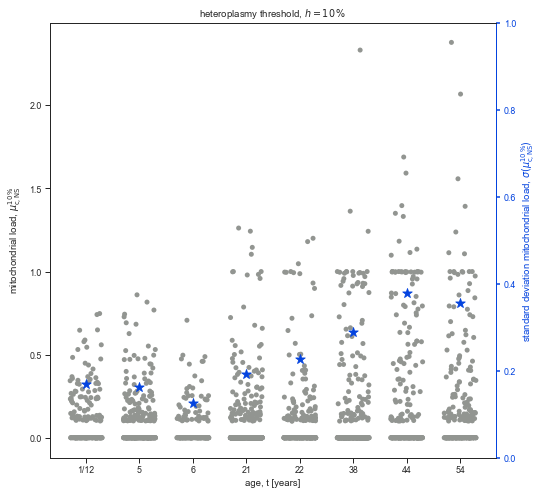

In [37]:
sns.set_context("paper")
sns.set_style("ticks")
plotMuVersusDonorAge(adata, varianceSubset,heteroplasmyThreshold=0.1,saveFig = './../../../publicationFigures/mitochondrialLoad/mitochondrialLoadVersusAge_t10.pdf')


FileNotFoundError: [Errno 2] No such file or directory: './figures/mitochondrialLoadVersusAge_t10_grey.pdf'

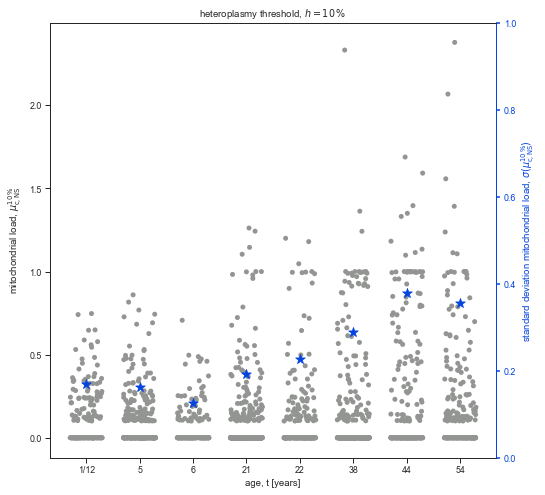

In [22]:
# compute mitochodnrial load as mean and variance over age
t=0.10
adataMu = computeMitochondrialLoad(adata,varianceSubset,threshold=t,removeSynonymous=1,mutantType=['Cryptic'],rescaling=False)
plotData = pd.DataFrame()
plotData['age'] = adataMu.obs['donor_age']

#plotData['age'][plotData['age'] == 1]=1/12

plotData['MU'] = adataMu.obs['MU']
plotData['cell type'] = adataMu.obs['cell_type']
plotData['highlight'] = plotData['cell type'] == 'alpha'

sns.set_context("paper")
sns.set_style("ticks")

# get mean and std for each age
unqiueAges = np.sort(plotData['age'].unique())
meanAge =[]
medianAge =[]
stdAge =[]
skewnessAge=[]
for age in np.sort(plotData['age'].unique()):
    meanAge.append(np.mean(plotData[plotData['age']==age])['MU'])
    stdAge.append(np.std(plotData[plotData['age']==age])['MU'])
    medianAge.append(np.median(plotData[plotData['age']==age]['MU']))
    skewnessAge.append(stats.skew(plotData[plotData['age']==age]['MU']))

fig, ax = plt.subplots(figsize=(8,8))



#g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,hue='highlight',palette=sns.xkcd_palette(["grey", "light red"]),ax=ax)
g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,hue='highlight',palette=sns.xkcd_palette(["grey"]),ax=ax)


g.get_legend().remove()
pearsonr = stats.pearsonr(plotData['age'],plotData['MU'])
spearmanr = stats.spearmanr(plotData['age'],plotData['MU'])

plotDataAlpha = plotData[plotData['highlight']==True]
pearsonrAlpha = stats.pearsonr(plotDataAlpha['age'],plotDataAlpha['MU'])

# plt.text(0, 5, r'alpha cells', fontsize=12,color= sns.xkcd_rgb["light red"])
# plt.text(0, 4.8, r'$r^2='+ str(round(pearsonrAlpha[0]**2,2)) + '$', fontsize=12,color= sns.xkcd_rgb["light red"])
# plt.text(0, 4.6, r'$p=10^{'+ str(int(round(np.log10(pearsonrAlpha[1]),0))) + '}$', fontsize=12,color= sns.xkcd_rgb["light red"])

# plt.text(0, 4, r'all cells', fontsize=12)
# plt.text(0, 3.8, r'$r^2='+ str(round(pearsonr[0]**2,2)) + '$', fontsize=12)
# plt.text(0, 3.6, r'$p=10^{'+ str(int(round(np.log10(pearsonr[1]),0))) + '}$', fontsize=12)


plt.xlabel('age, t [years]')
plt.ylabel(r'mitochondrial load, $\mu_{\mathrm{c,NS}}^{10\,\%}$')

# plot the standard deviation
ax2 =ax.twinx()

secondColour = sns.xkcd_rgb["blue"]

#sns.scatterplot(x=np.arange(0,8,1),y=stdAge,ax=ax2)
ax2.scatter(x=np.arange(0,8,1),y=stdAge,c=secondColour,marker='*',s=100)
ax2.set_ylabel(r'standard deviation mitochondrial load, $\sigma (\mu_{\mathrm{c,NS}}^{10\,\%})$')
ax2.yaxis.label.set_color(secondColour)
ax2.spines['right'].set_color(secondColour)
tkw = dict(size=4, width=1.5)
ax2.tick_params(axis='y', colors=secondColour, **tkw)
ax2.set_ylim(0, 1)

g.set(xticklabels=['1/12',5,6,21,22,38,44,54
                  ])
plt.title(r'heteroplasmy threshold, $h=10\,\%$')

plt.savefig('./figures/mitochondrialLoadVersusAge_t10_grey.pdf')
plt.savefig('./figures/mitochondrialLoadVersusAge_t10_grey.svg')

#print(stats.spearmanr(plotData['age'],plotData['MU']))
#print()



In [9]:
spearmanr

SpearmanrResult(correlation=0.04076217131250186, pvalue=0.048130978766036316)

In [10]:
pearsonr

(0.1506669396762293, 2.0811735819962216e-13)

In [24]:
spearmanr[0]

[0.041395119982483436,
 0.07878869575689484,
 0.0,
 0.16552182644489,
 0.18625587158150783,
 0.25959434652155944,
 0.35782385415458656,
 0.30865163780758803]

## 30% threshold

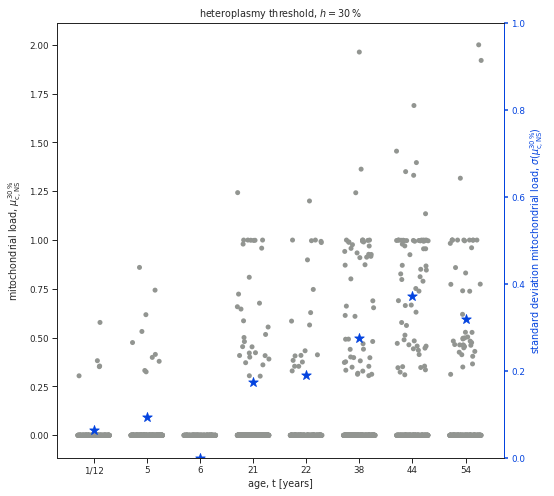

In [10]:
# compute mitochodnrial load as mean and variance over age
t=0.30
adataMu = computeMitochondrialLoad(adata,varianceSubset,threshold=t,removeSynonymous=1,mutantType=['Cryptic'],rescaling=False)
plotData = pd.DataFrame()
plotData['age'] = adataMu.obs['donor_age']

#plotData['age'][plotData['age'] == 1]=1/12

plotData['MU'] = adataMu.obs['MU']
plotData['cell type'] = adataMu.obs['cell_type']
plotData['highlight'] = plotData['cell type'] == 'alpha'

sns.set_context("paper")
sns.set_style("ticks")

# get mean and std for each age
unqiueAges = np.sort(plotData['age'].unique())
meanAge =[]
medianAge =[]
stdAge =[]
skewnessAge=[]
for age in np.sort(plotData['age'].unique()):
    meanAge.append(np.mean(plotData[plotData['age']==age])['MU'])
    stdAge.append(np.std(plotData[plotData['age']==age])['MU'])
    medianAge.append(np.median(plotData[plotData['age']==age]['MU']))
    skewnessAge.append(stats.skew(plotData[plotData['age']==age]['MU']))

fig, ax = plt.subplots(figsize=(8,8))



#g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,hue='highlight',palette=sns.xkcd_palette(["grey", "light red"]),ax=ax)
g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,hue='highlight',palette=sns.xkcd_palette(["grey"]),ax=ax)


g.get_legend().remove()
pearsonr = stats.pearsonr(plotData['age'],plotData['MU'])
spearmanr = stats.spearmanr(plotData['age'],plotData['MU'])

plotDataAlpha = plotData[plotData['highlight']==True]
pearsonrAlpha = stats.pearsonr(plotDataAlpha['age'],plotDataAlpha['MU'])

# plt.text(0, 5, r'alpha cells', fontsize=12,color= sns.xkcd_rgb["light red"])
# plt.text(0, 4.8, r'$r^2='+ str(round(pearsonrAlpha[0]**2,2)) + '$', fontsize=12,color= sns.xkcd_rgb["light red"])
# plt.text(0, 4.6, r'$p=10^{'+ str(int(round(np.log10(pearsonrAlpha[1]),0))) + '}$', fontsize=12,color= sns.xkcd_rgb["light red"])

# plt.text(0, 4, r'all cells', fontsize=12)
# plt.text(0, 3.8, r'$r^2='+ str(round(pearsonr[0]**2,2)) + '$', fontsize=12)
# plt.text(0, 3.6, r'$p=10^{'+ str(int(round(np.log10(pearsonr[1]),0))) + '}$', fontsize=12)


plt.xlabel('age, t [years]')
plt.ylabel(r'mitochondrial load, $\mu_{\mathrm{c,NS}}^{30\,\%}$')

# plot the standard deviation
ax2 =ax.twinx()

secondColour = sns.xkcd_rgb["blue"]

#sns.scatterplot(x=np.arange(0,8,1),y=stdAge,ax=ax2)
ax2.scatter(x=np.arange(0,8,1),y=stdAge,c=secondColour,marker='*',s=100)
ax2.set_ylabel(r'standard deviation mitochondrial load, $\sigma (\mu_{\mathrm{c,NS}}^{30\,\%})$')
ax2.yaxis.label.set_color(secondColour)
ax2.spines['right'].set_color(secondColour)
tkw = dict(size=4, width=1.5)
ax2.tick_params(axis='y', colors=secondColour, **tkw)
ax2.set_ylim(0, 1)

g.set(xticklabels=['1/12',5,6,21,22,38,44,54
                  ])
plt.title(r'heteroplasmy threshold, $h=30\,\%$')

plt.savefig('./figures/mitochondrialLoadVersusAge_t30_grey.pdf')
#print(stats.spearmanr(plotData['age'],plotData['MU']))
#print()



In [16]:
spearmanr

SpearmanrResult(correlation=0.22022568191193226, pvalue=3.247189941321501e-27)

In [17]:
pearsonr

(0.22200961683421636, 1.2160870495904647e-27)

## Threshold 40%

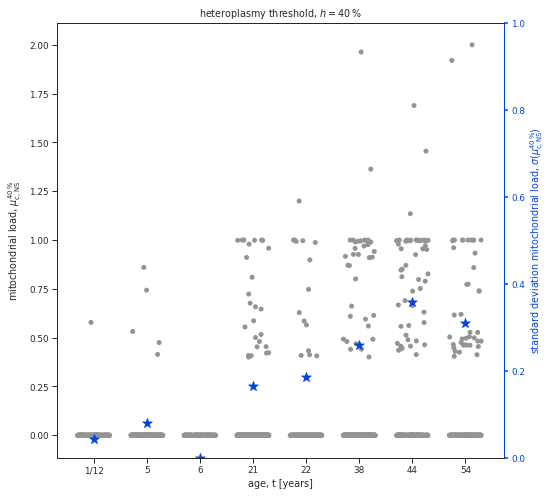

In [11]:
# compute mitochodnrial load as mean and variance over age
t=0.40
adataMu = computeMitochondrialLoad(adata,varianceSubset,threshold=t,removeSynonymous=1,mutantType=['Cryptic'],rescaling=False)
plotData = pd.DataFrame()
plotData['age'] = adataMu.obs['donor_age']

#plotData['age'][plotData['age'] == 1]=1/12

plotData['MU'] = adataMu.obs['MU']
plotData['cell type'] = adataMu.obs['cell_type']
plotData['highlight'] = plotData['cell type'] == 'alpha'

sns.set_context("paper")
sns.set_style("ticks")

# get mean and std for each age
unqiueAges = np.sort(plotData['age'].unique())
meanAge =[]
medianAge =[]
stdAge =[]
skewnessAge=[]
for age in np.sort(plotData['age'].unique()):
    meanAge.append(np.mean(plotData[plotData['age']==age])['MU'])
    stdAge.append(np.std(plotData[plotData['age']==age])['MU'])
    medianAge.append(np.median(plotData[plotData['age']==age]['MU']))
    skewnessAge.append(stats.skew(plotData[plotData['age']==age]['MU']))

fig, ax = plt.subplots(figsize=(8,8))



#g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,hue='highlight',palette=sns.xkcd_palette(["grey", "light red"]),ax=ax)
g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,hue='highlight',palette=sns.xkcd_palette(["grey"]),ax=ax)


g.get_legend().remove()
pearsonr = stats.pearsonr(plotData['age'],plotData['MU'])
spearmanr = stats.spearmanr(plotData['age'],plotData['MU'])

plotDataAlpha = plotData[plotData['highlight']==True]
pearsonrAlpha = stats.pearsonr(plotDataAlpha['age'],plotDataAlpha['MU'])

# plt.text(0, 5, r'alpha cells', fontsize=12,color= sns.xkcd_rgb["light red"])
# plt.text(0, 4.8, r'$r^2='+ str(round(pearsonrAlpha[0]**2,2)) + '$', fontsize=12,color= sns.xkcd_rgb["light red"])
# plt.text(0, 4.6, r'$p=10^{'+ str(int(round(np.log10(pearsonrAlpha[1]),0))) + '}$', fontsize=12,color= sns.xkcd_rgb["light red"])

# plt.text(0, 4, r'all cells', fontsize=12)
# plt.text(0, 3.8, r'$r^2='+ str(round(pearsonr[0]**2,2)) + '$', fontsize=12)
# plt.text(0, 3.6, r'$p=10^{'+ str(int(round(np.log10(pearsonr[1]),0))) + '}$', fontsize=12)


plt.xlabel('age, t [years]')
plt.ylabel(r'mitochondrial load, $\mu_{\mathrm{c,NS}}^{40\,\%}$')

# plot the standard deviation
ax2 =ax.twinx()

secondColour = sns.xkcd_rgb["blue"]

#sns.scatterplot(x=np.arange(0,8,1),y=stdAge,ax=ax2)
ax2.scatter(x=np.arange(0,8,1),y=stdAge,c=secondColour,marker='*',s=100)
ax2.set_ylabel(r'standard deviation mitochondrial load, $\sigma (\mu_{\mathrm{c,NS}}^{40\,\%})$')
ax2.yaxis.label.set_color(secondColour)
ax2.spines['right'].set_color(secondColour)
tkw = dict(size=4, width=1.5)
ax2.tick_params(axis='y', colors=secondColour, **tkw)
ax2.set_ylim(0, 1)

g.set(xticklabels=['1/12',5,6,21,22,38,44,54
                  ])
plt.title(r'heteroplasmy threshold, $h=40\,\%$')
plt.savefig('./figures/mitochondrialLoadVersusAge_t40_grey.pdf')
#print(stats.spearmanr(plotData['age'],plotData['MU']))
#print()



## Threshold 90%

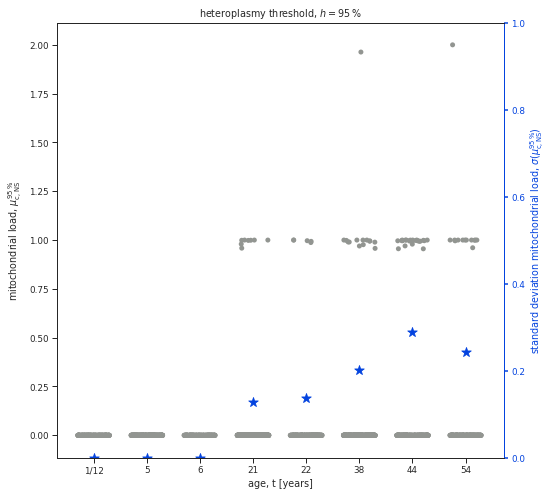

In [12]:
# compute mitochodnrial load as mean and variance over age
t=0.95
adataMu = computeMitochondrialLoad(adata,varianceSubset,threshold=t,removeSynonymous=1,mutantType=['Cryptic'],rescaling=False)
plotData = pd.DataFrame()
plotData['age'] = adataMu.obs['donor_age']

#plotData['age'][plotData['age'] == 1]=1/12

plotData['MU'] = adataMu.obs['MU']
plotData['cell type'] = adataMu.obs['cell_type']
plotData['highlight'] = plotData['cell type'] == 'alpha'

sns.set_context("paper")
sns.set_style("ticks")

# get mean and std for each age
unqiueAges = np.sort(plotData['age'].unique())
meanAge =[]
medianAge =[]
stdAge =[]
skewnessAge=[]
for age in np.sort(plotData['age'].unique()):
    meanAge.append(np.mean(plotData[plotData['age']==age])['MU'])
    stdAge.append(np.std(plotData[plotData['age']==age])['MU'])
    medianAge.append(np.median(plotData[plotData['age']==age]['MU']))
    skewnessAge.append(stats.skew(plotData[plotData['age']==age]['MU']))

fig, ax = plt.subplots(figsize=(8,8))



#g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,hue='highlight',palette=sns.xkcd_palette(["grey", "light red"]),ax=ax)
g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,hue='highlight',palette=sns.xkcd_palette(["grey"]),ax=ax)


g.get_legend().remove()
pearsonr = stats.pearsonr(plotData['age'],plotData['MU'])
spearmanr = stats.spearmanr(plotData['age'],plotData['MU'])

plotDataAlpha = plotData[plotData['highlight']==True]
pearsonrAlpha = stats.pearsonr(plotDataAlpha['age'],plotDataAlpha['MU'])

# plt.text(0, 5, r'alpha cells', fontsize=12,color= sns.xkcd_rgb["light red"])
# plt.text(0, 4.8, r'$r^2='+ str(round(pearsonrAlpha[0]**2,2)) + '$', fontsize=12,color= sns.xkcd_rgb["light red"])
# plt.text(0, 4.6, r'$p=10^{'+ str(int(round(np.log10(pearsonrAlpha[1]),0))) + '}$', fontsize=12,color= sns.xkcd_rgb["light red"])

# plt.text(0, 4, r'all cells', fontsize=12)
# plt.text(0, 3.8, r'$r^2='+ str(round(pearsonr[0]**2,2)) + '$', fontsize=12)
# plt.text(0, 3.6, r'$p=10^{'+ str(int(round(np.log10(pearsonr[1]),0))) + '}$', fontsize=12)


plt.xlabel('age, t [years]')
plt.ylabel(r'mitochondrial load, $\mu_{\mathrm{c,NS}}^{95\,\%}$')

# plot the standard deviation
ax2 =ax.twinx()

secondColour = sns.xkcd_rgb["blue"]

#sns.scatterplot(x=np.arange(0,8,1),y=stdAge,ax=ax2)
ax2.scatter(x=np.arange(0,8,1),y=stdAge,c=secondColour,marker='*',s=100)
ax2.set_ylabel(r'standard deviation mitochondrial load, $\sigma (\mu_{\mathrm{c,NS}}^{95\,\%})$')
ax2.yaxis.label.set_color(secondColour)
ax2.spines['right'].set_color(secondColour)
tkw = dict(size=4, width=1.5)
ax2.tick_params(axis='y', colors=secondColour, **tkw)
ax2.set_ylim(0, 1)

g.set(xticklabels=['1/12',5,6,21,22,38,44,54
                  ])
plt.title(r'heteroplasmy threshold, $h=95\,\%$')
plt.savefig('./figures/mitochondrialLoadVersusAge_t95_grey.pdf')
#print(stats.spearmanr(plotData['age'],plotData['MU']))
#print()



## Vary the threshold

In [15]:
def computeSTDage(dataIn):
    # get mean and std for each age
    unqiueAges = np.sort(dataIn['age'].unique())
    stdAge =[]

    for age in np.sort(dataIn['age'].unique()):
        stdAge.append(np.std(dataIn[dataIn['age']==age])['MU'])
    return(stdAge)



pearsonOut = []
spearmanOut = []

spearmanStdOut = []







#thresholds= np.arange(0,1,0.01)
thresholds = [0.1,0.1]
for t in thresholds:
    adataMu = computeMitochondrialLoad(adata,varianceSubset,threshold=t,removeSynonymous=1,mutantType=['Cryptic'],rescaling=False)
    plotData = pd.DataFrame()
    plotData['age'] = adataMu.obs['donor_age']
    plotData['MU'] = adataMu.obs['MU']
    
    # compute the std
    stdAgeMu = computeSTDage(plotData)
    
    
    pearsonr = stats.pearsonr(plotData['age'],plotData['MU'])
    pearsonOut.append(pearsonr[1])
    spearmanr = stats.spearmanr(plotData['age'],plotData['MU'])
    spearmanOut.append(spearmanr[1])

    spearmanrStd = stats.spearmanr(np.sort(plotData['age'].unique()),stdAgeMu)
    spearmanStdOut.append(spearmanrStd[1])


In [16]:
spearmanrStd

SpearmanrResult(correlation=0.880952380952381, pvalue=0.0038503204637324014)

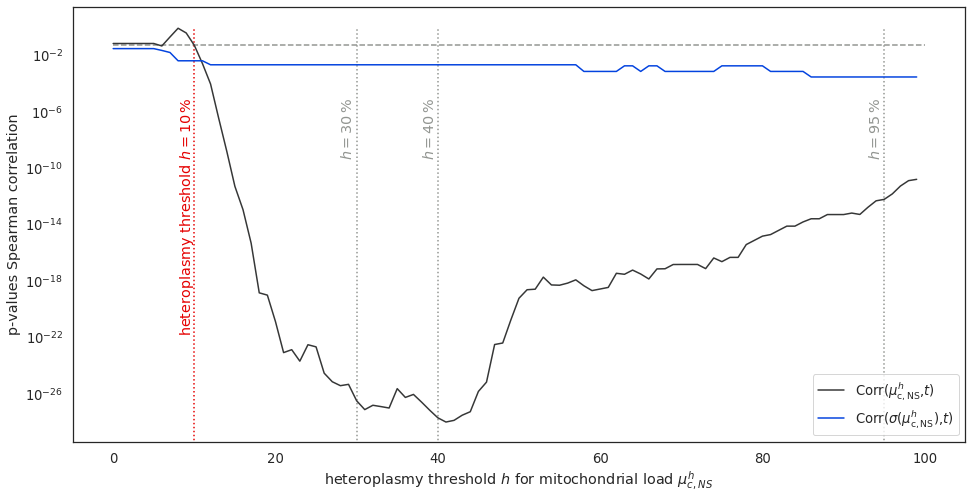

In [86]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(thresholds*100,spearmanOut,label=r'Corr($\mu_{\mathrm{c,NS}}^{h}$,$t$)',color=sns.xkcd_rgb["dark grey"])
plt.plot(thresholds*100,spearmanStdOut,label=r'Corr($\sigma(\mu_{\mathrm{c,NS}}^{h})$,$t$)',color=sns.xkcd_rgb["blue"])
#plt.scatter(thresholds[10],spearmanOut[10])

# significnace threshold
plt.hlines(0.05,0,100, linestyles='dashed',color=sns.xkcd_rgb["grey"])

# plot vertical lines


first=True

for x in [10,30,40,95]:
    
    
    # first is highlighted
    if first:
        labelText = r'heteroplasmy threshold $h='+str(x)+'\,\%$'
        plt.vlines(x,0,1, linestyles='dotted',color=sns.xkcd_rgb["red"])
        plt.text(x-2,10**(-5),labelText,rotation=90,color=sns.xkcd_rgb["red"],va='top')
        
        first=False
    else:
        labelText = r'$h='+str(x)+'\,\%$'
        plt.vlines(x,0,1, linestyles='dotted',color=sns.xkcd_rgb["grey"])
        plt.text(x-2,10**(-5),labelText,rotation=90,color=sns.xkcd_rgb["grey"],va='top')
    
# plt.vlines(0.1*100,0,1, linestyles='dashed',color=sns.xkcd_rgb["grey"])
# plt.vlines(0.3*100,0,1, linestyles='dashed',color=sns.xkcd_rgb["grey"])
# plt.vlines(0.4*100,0,1, linestyles='dashed',color=sns.xkcd_rgb["grey"])
# plt.vlines(0.95*100,0,1, linestyles='dashed',color=sns.xkcd_rgb["grey"])


# add text to lines

#plt.text((0.1-0.04)*100,10**(-10),r'$h=10\,\%$',rotation=90)

plt.yscale("log")
plt.xlabel(r'heteroplasmy threshold $h$ for mitochondrial load $\mu^h_{c,NS}$')
plt.ylabel(r'p-values Spearman correlation')
plt.legend(loc='lower right')
plt.savefig('./figures/spearmanCorrelationHvar.pdf')